# 한국어 데이터로 챗봇 만들기

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# Step 1. 데이터 수집하기

In [2]:
csv_path = os.getenv('HOME') + '/aiffel/transformer_chatbot/data/ChatbotData .csv'

df= pd.read_csv(csv_path)
df

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


# Step 2. 데이터 전처리하기

영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.

In [3]:
# null 확인 >> 없음
null = pd.DataFrame(df.dtypes, columns=['datatype'])
null = null.reset_index()
null['null count'] = df.isnull().sum().values
null['null ratio'] = null['null count']/df.shape[0]
null['unique count'] = df.nunique().values
print(df.shape)
null

(11823, 3)


,index,datatype,null count,null ratio,unique count
0,Q,object,0,0.0,11662
1,A,object,0,0.0,7779
2,label,int64,0,0.0,3


In [4]:
# 중복확인 >> 전체중복 없음, 칼럼중복 : 161, 4044개 >> 중복 드롭 니니함
dupli = {}
dupli['dupli whole'] = df.duplicated().sum()
dupli['dupli Q columns'] = df.duplicated(subset=['Q']).sum()
dupli['dupli A columns'] = df.duplicated(subset=['A']).sum()
dupli_Q = df[df.duplicated(subset=['Q'])]
dupli_A = df[df.duplicated(subset=['A'])]
print(dupli)
dupli_Q

{'dupli whole': 0, 'dupli Q columns': 161, 'dupli A columns': 4044}


,Q,A,label
196,고양이 키우고 싶어,가족들과 상의해보세요.,0
235,공시 준비 힘들어,잘 될 거예요.,0
1294,돈 벌고 싶어,많이 벌수록 좋아요.,0
1445,로또 번호 알려줘,알면 제가 하죠.,0
1481,마음이 울적해,거리를 걸어보세요.,0
...,...,...,...
11642,착해서 잘해주는 건지 좋아하는 건지,헷갈린다고 말해보세요.,2
11649,첫 눈에 반하는게 가능해?,당연히 가능하죠.,2
11658,첫사랑 생각나,지금의 사랑에 충실하세요.,2
11732,커플여행이 나을까 그냥 우리끼리 갈까?,저는 둘이 가는 게 좋아요.,2


In [5]:
dupli_A

,Q,A,label
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.,0
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.,0
12,가끔 뭐하는지 궁금해,그 사람도 그럴 거예요.,0
18,가스불 켜놓고 나온거 같아,빨리 집에 돌아가서 끄고 나오세요.,0
...,...,...,...
11806,혼자만 설레고 혼자서 끝내는 짝사랑 그만할래.,맘고생 많았어요.,2
11807,화이트데이에 고백할까요?,선물을 주면서 솔직하고 당당하게 고백해보세요.,2
11809,확실히 날 좋아하는 걸 아는 남자랑 친구가 될 수 있을까?,그 사람을 위해서는 그러면 안돼요.,2
11816,회식하는데 나만 챙겨줘. 썸임?,호감이 있을 수도 있어요. 그렇지만 조금 더 상황을 지켜보세요.,2


In [6]:
# 샘플 최대갯수 
MAX_SAMPLES = df.shape[0]
print(MAX_SAMPLES)

11823


In [7]:
# 쓰여진 모든 특수문자 찾기

def used_special_characters(column):
    special_characters = df[column].apply(lambda x: re.findall(r'[^\w\s]+', x))
    unique_special_characters = list(set([item for sublist in special_characters for item in sublist]))
    return unique_special_characters

print(used_special_characters('Q'))
print(used_special_characters('A'))

['!!', '.?', "'", '.!', ';;;', '~~~~', '.!!', ';;', ';?', ',', '….', '~', '!?', '~!!', '??', '~??', '.', '???', '!!!', '%', '?.', ',.', '~~', '~~~', '..', '?', '!', '…', ',,']
['!!', '!', '....', '.-', "',", '..', "'", '.', ',', '?', '~', '-', '…']


In [8]:
# 사용할 특수문자만 남기고 클리닝하기

def clean_special_characters(column):
    df[column] = df[column].apply(lambda x: re.sub(r'[^\w\s](?![,!?.]{2,})[,!?.]', '', x))
    return df[column]

df['Q'] = clean_special_characters('Q')
df['A'] = clean_special_characters('A')
print(used_special_characters('Q'))
print(used_special_characters('A'))

[';;;', '!', '%', '~~~~', '~~', '~~~', "'", ';;', '.', ',', '?', '~', '…']
['!', '.-', '..', "'", '.', ',', '?', '~', '-', '…']


In [9]:
# inputs, outputs 정하기

questions = df['Q'].values
answers = df['A'].values

print("questions shape :",questions.shape)
print("answers shape :",answers.shape)

questions shape : (11823,)
answers shape : (11823,)


In [10]:
print('전처리 후의 11650번째 질문 샘플: {}'.format(questions[11649]))
print('전처리 후의 11650번째 답변 샘플: {}'.format(answers[11649]))
print('챗봇 너무 똑똑이! 난 너한테 반함!')

전처리 후의 11650번째 질문 샘플: 첫 눈에 반하는게 가능해?
전처리 후의 11650번째 답변 샘플: 당연히 가능하죠.
챗봇 너무 똑똑이! 난 너한테 반함!


In [11]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

# Step 3. SubwordTextEncoder 사용하기

한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.

- TensorFlow Datasets SubwordTextEncoder 를 토크나이저로 사용한다. 단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고, 각 토큰을 고유한 정수로 인코딩 한다.
- 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 START_TOKEN 및 END_TOKEN을 추가한다.
- 최대 길이 MAX_LENGTH 인 40을 넘는 문장들은 필터링한다.
- MAX_LENGTH보다 길이가 짧은 문장들은 40에 맞도록 패딩 한다.

>## 1) 단어장(Vocabulary) 만들기

In [12]:
# Q, A Vocabulary 생성

import tensorflow_datasets as tfds
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=8359)

The purpose of the tokenizer is to convert a string of text into a sequence of tokens, where each token is a numerical representation of a word or subword unit. The SubwordTextEncoder class uses a subword tokenization method, which means it can split words into subword units, making the tokenization process more robust and less prone to out-of-vocabulary (OOV) tokens. The build_from_corpus method trains the tokenizer on the provided text data and creates the vocabulary.  

The 2^13 means 2 raised to the power of 13, or 2 to the 13th power. It is used as the target_vocab_size argument for the SubwordTextEncoder.build_from_corpus method.  
The target_vocab_size argument is used to determine the number of tokens to be used in the encoding. In this case, a vocabulary size of 2^13 tokens is chosen. The choice of vocabulary size depends on the complexity of the data being processed and the desired balance between compression and accuracy.  
By using a smaller vocabulary size, you can reduce the amount of memory required to store the encoding and speed up processing time, but you may also lose information and accuracy in the encoding. Conversely, a larger vocabulary size may provide more accurate encodings but will require more memory and processing time.  
In this example, the choice of 2^13 as the vocabulary size is arbitrary and may or may not be appropriate for your specific use case. You may want to experiment with different vocabulary sizes to see what works best for your specific data and requirements. (answered by chatopenai)                

<mark> 2**13 >> 8359로 revised </mark>

In [13]:
# 시작 토큰과 종료 토큰에 고유한 정수 부여
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [14]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8357]
END_TOKEN의 번호 : [8358]


In [15]:
# 시작 토큰과 종료 토큰을 고려하여 +2 를 하여 VOCAB_SIZE
VOCAB_SIZE = tokenizer.vocab_size + 2
print('VOCAB_SIZE :',VOCAB_SIZE)

VOCAB_SIZE : 8359


>## 2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)
위에서 tensorflow_datasets의 SubwordTextEncoder를 사용해서 tokenizer를 정의하고 Vocabulary를 만들었다면, tokenizer.encode()로 각 단어를 정수로 변환할 수 있고 또는 tokenizer.decode()를 통해 정수 시퀀스를 단어 시퀀스로 변환할 수 있습니다.

>>### 2-1. Encoding

In [16]:
# 임의의 11650번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('전처리 후의 11650번째 질문 샘플: {}'.format(questions[11649]))
print('전처리 후의 11650번째 답변 샘플: {}'.format(answers[11649]))
print('정수 인코딩 후의 11650번째 질문 샘플: {}'.format(tokenizer.encode(questions[11649])))
print('정수 인코딩 후의 11650번째 답변 샘플: {}'.format(tokenizer.encode(answers[11649])))

전처리 후의 11650번째 질문 샘플: 첫 눈에 반하는게 가능해?
전처리 후의 11650번째 답변 샘플: 당연히 가능하죠.
정수 인코딩 후의 11650번째 질문 샘플: [1604, 1442, 378, 432, 3770, 8164]
정수 인코딩 후의 11650번째 답변 샘플: [4481, 8071, 8147]


In [17]:
# # 인코딩 한 값 디코딩해서 결과 확인해보기

# def idx_to_text(element):
#     encoded_example = tokenizer.encode(element)
#     decoded_example = [tokenizer.decode([token]) for token in encoded_example]
#     print("해당값 디코딩 결과: \n".format(element))
#     for i, token in enumerate(encoded_example):
#         print("{} : {}".format(token, decoded_example[i]))
    
# idx_to_text(questions[11649])      
# idx_to_text(answers[11649])    

>>### 2-2. Padding

questions 최소 길이 : 1
questions 최대 길이 : 15
questions 평균 길이 : 3.5872452000338324
answers 최소 길이 : 1
answers 최대 길이 : 21
answers 평균 길이 : 3.6936479742874058


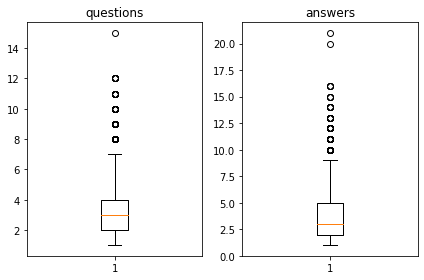

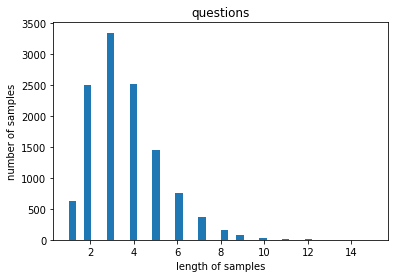

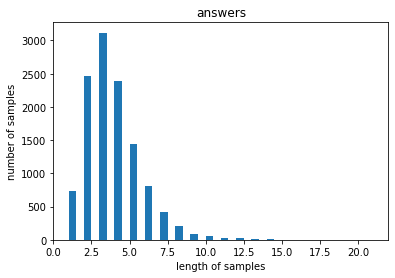

In [18]:
# 길이 분포 출력
import matplotlib.pyplot as plt

questions_len = [len(s.split()) for s in df['Q']]
answers_len = [len(s.split()) for s in df['A']]

print('questions 최소 길이 : {}'.format(np.min(questions_len)))
print('questions 최대 길이 : {}'.format(np.max(questions_len)))
print('questions 평균 길이 : {}'.format(np.mean(questions_len)))
print('answers 최소 길이 : {}'.format(np.min(answers_len)))
print('answers 최대 길이 : {}'.format(np.max(answers_len)))
print('answers 평균 길이 : {}'.format(np.mean(answers_len)))

plt.subplot(1,2,1)
plt.boxplot(questions_len)
plt.title('questions')
plt.subplot(1,2,2)
plt.boxplot(answers_len)
plt.title('answers')
plt.tight_layout()
plt.show()

plt.title('questions')
plt.hist(questions_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('answers')
plt.hist(answers_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [19]:
# 데이터의 몇프로인지 계산하는 함수

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))


In [20]:
MAX_LENGTH = 40
below_threshold_len(MAX_LENGTH, df['Q'])
below_threshold_len(MAX_LENGTH,  df['A'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 40 이하인 샘플의 비율: 1.0


<mark> 처음에 80% 정도만 하려고 조정을 하다가,, 데이터도 너무 적고, 최대 길이도 얼마되지 않아서 그냥 넉넉한 최대치로 lms와 동일하게 40을 줬다. <\mark> 

In [21]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거 & 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # 최대 길이로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [22]:
questions, answers = tokenize_and_filter(questions, answers)

In [23]:
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8359
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


In [24]:
print(type(questions))
print(questions[11649])

<class 'numpy.ndarray'>
[8357 1604 1442  378  432 3770 8164 8358    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


>## 3. 교사 강요(Teacher Forcing)  

트랜스포머는 인코더, 디코더 모두 교사 강요(Teacher Forcing) 를 적용합니다.
교사 강요를 적용하기 위해서 위 샘플을 디코더의 입력과 레이블로 사용한다고 하였을 때, 각각 어떻게 수정해서 입력과 레이블로 사용해야 할까요?  
질문과 답변의 쌍을 tf.data.Dataset API의 입력으로 사용하여 파이프라인을 구성합니다. 

이때, 교사 강요를 위해서 answers[:, :-1]를 디코더의 입력값, answers[:, 1:]를 디코더의 레이블로 사용합니다.  
입력 : \<START_TOKEN> I AM A STUDENT \<END_TOKEN> \<PAD> \<PAD> \<PAD>  
레이블 : I AM A STUDENT \<END_TOKEN> \<PAD> \<PAD> \<PAD> \<PAD>    

In [25]:
# questions 형태 확인하기
print(questions[0])
print(questions.shape)

[8357 8096 1530 3058 8134 8358    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
(11823, 40)


그 전 모델에서는 model.fit할 때,
    
    - x : encoder_input_train, decoder_input_train(인코터 어텐션과 인풋 받아서 학습시켜 예측을 통해 예상 타겟값)
    - y : decoder_target_train 을 넣어서 그 둘의 accuracy를 비교했다. 

하지만 Transformer decoder 만들 때는,  

- 입력 : \<START_TOKEN> I AM A STUDENT \<END_TOKEN> \<PAD> \<PAD> \<PAD>  
- 레이블 : I AM A STUDENT \<END_TOKEN> \<PAD> \<PAD> \<PAD> \<PAD>  

이렇게 되어야 하므로,
- decoder_input은 뒤에 pad 하나 떼도록 [:,:-1]로 슬라이싱하고,  
- decoder_output은 앞에 start_token 떼도록 [:,1:]로 슬라이싱한다.

In [26]:
# 슬라이싱 전에 answers 형태 확인하고
print(answers[0])
print(answers.shape)

[8357 3842   69 8075 8147 8358    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
(11823, 40)


In [27]:
# transformer decoder에 쓸 input, output으로 슬라이싱 해주기

BATCH_SIZE = 64
BUFFER_SIZE = 20000
dataset = tf.data.Dataset.from_tensor_slices((
    {'inputs': questions,
     'dec_inputs': answers[:, :-1]},
    
    {'outputs': answers[:, 1:]},
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [28]:
dataset

<PrefetchDataset shapes: ({inputs: (None, 40), dec_inputs: (None, 39)}, {outputs: (None, 39)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>

# Step 4. 모델 구성하기

![2.PNG](2.PNG)

# Transfer 구현시 만들어야하는 함수들  

#### A. Attention layer 만들어 준비하기  
1. positional encoding  
2. Multi heads Self Attiention   
    2-1. Scaled Dot Product   
    2-2. Mask 함수 2개  
    
#### B. 인코더   
1. 인코더 한개 블럭 만들기  
2. 인코더 블럭 여러개 쌓기  

#### C. 디코더  
1. 디코더 한개 블럭 만들기  
2. 디코더 블럭 여러개 쌓기  

#### D. 트랜스포머 구현하기  
1. 하이퍼 파라미터  
2. 손실함수  
3. 학습률  

>## A. Attention layer 만들어 준비하기

In [29]:
# 1. positional encoding

class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [30]:
# 2-1. in Self Attention layer

def scaled_dot_product_attention(query, key, value, mask):
    
    # 1.어텐션 가중치는 Q와 K의 닷 프로덕트 = 어텐션 스코어 행렬 = 어텐션에너지
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 2.가중치를 정규화 & dk의 루트값으로 나눠준다
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 2-3.패딩에 마스크 추가
    # 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
    # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
    if mask is not None:
        logits += (mask * -1e9)

    # 3.softmax적용 마지막 차원인 key의 문장 길이 방향으로 수행된다.
    # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 4.최종 어텐션은 가중치와 V의 닷 프로덕트
    # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    output = tf.matmul(attention_weights, value)
    return output

# output : (batch_size, num_heads, seq_len_q, depth)

In [31]:
# 2. 멀티헤드 어텐션 함수 (스케일드 닷 프로덕트 어텐션 함수도 안에 포함됨)
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads
        
        ## 2-3 사이에 멀티헤드할 준비작업들
        # Q,K,V 지정 후 d_model 전체차원을 통과시켜서(가중치W 곱해서) WQ,WK,Wv로 정의
        self.query_dense = tf.keras.layers.Dense(units=d_model) # Q 지정 
        self.key_dense = tf.keras.layers.Dense(units=d_model)   # K 지정
        self.value_dense = tf.keras.layers.Dense(units=d_model) # V 지정

        self.dense = tf.keras.layers.Dense(units=d_model)

        # num_heads 개수만큼 q, k, v를 split하는 함수
    def split_heads(self, inputs, batch_size): # 나눌 헤드수와 reshape
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3]) # 전치시키는것

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]
        
        # 1. WQ, WK, WV에 해당하는 밀집층 지나기 (W : 실질적가중치)
        # q : (batch_size, query의 문장 길이, d_model)
        # k : (batch_size, key의 문장 길이, d_model)
        # v : (batch_size, value의 문장 길이, d_model)
        # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
#################################################################################
        
        # 1-2 사이. 헤드 나누기
        # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
        # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
        
        # 병렬 연산을 위해 머리만큼 Q,K,V 나눠주기
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

 #################################################################################

        # 2-4. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
        # 2.일정수로 나눠서 정규화하고,
        # 2-3.(필요하면 mask 씌워서 값 무시하게 해주고,)
        # 3.Softmax로 0-1사이의 확률값으로 바꾸고
        # 4.V 곱해서 최종 어텐션값 구하기
        # output = (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        
 #################################################################################

        # 5. 행렬곱 전에 순서를 맞춰서 transpose해주기
        # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

 #################################################################################
    
        # 6. 헤드 연결(concatenate)하기
        # (batch_size, query의 문장 길이, d_model)
        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

#################################################################################

        # 7. WO에 해당하는 dense층 지나기
        # (batch_size, query의 문장 길이, d_model)
        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

In [32]:
# 2-2. Mask 함수 1

def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [33]:
# 2-2. Mask 함수 2

def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

>## B. 인코더

In [34]:
# 1. 인코더 한개 블럭 만들기

def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    # 인코더의 입력으로 들어가는 문장에는 0패딩이 있을 수 있으므로, 
    # 어텐션 시 패딩 토큰을 제외하도록 패딩 마스크를 사용합니다.
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 1. 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
    
    # 1-2. 드롭아웃 + 잔차 연결과 층 정규화
    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)
    
    # 2. 포지션 와이즈 FFNN 레이어
    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    # 2-2. 드롭아웃 + 잔차 연결과 층 정규화
    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [35]:
# 2. 인코더 블럭 여러개 쌓기

def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 준비 (디코더와 달리 단순히 0으로 붙은것만 가리는 것)
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 0-1. 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 0-2. 포지셔널 인코딩 + 드롭아웃
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings) #앞서 만든 클래스
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 인코더를 num_layers개 쌓기 (논문에서는 6개)
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

>## C. 디코더

In [36]:
# 1. 디코더 한개 블럭 만들기  

def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    
    # 룩어헤드 마스크(첫번째 서브층) 준비
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
    # 패딩 마스크(두번째 서브층) 준비
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 1. 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask ## 중요! 룩어헤드 마스크
      })

    # 1-2. 잔차 연결과 층 정규화
    attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

    # 2. 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask  # 패딩 마스크
      })

    # 2-2. 드롭아웃 + 잔차 연결과 층 정규화
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

    # 3. 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 3-2. 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [37]:
# 2. 디코더 블럭 여러개 쌓기  

def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')

    # 인코더 아웃풋을 인풋으로 넣어주고 (인코더랑 다른점)
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    
    # 룩어헤드 마스크 준비 (인코더랑 다른점)
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
    # 패딩 마스크준비 (인코더는 이것만 썼음)
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 0-1. 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 0-2. 포지셔널 인코딩 + 드롭아웃
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs, name=name)

>## D. 트랜스포머 구현하기  

In [38]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    
    # 인코더의 입력
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    # 디코더의 입력
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")
    
#######################################################
    
    # 인코더의 패딩 마스크 준비
    enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
    # 디코더의 룩어헤드 마스크(첫번째 서브층) 준비
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
    # 디코더의 패딩 마스크(두번째 서브층) 준비
    dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

#######################################################

    # 인코더
    # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
    enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

#######################################################

    # 디코더
    # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
    dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

#######################################################

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


num_layers, d-Model, units는 전부 사용자가 정할 수 있는 하이퍼파라미터 값입니다.  
논문에서 num_layers는 6, d-Model은 512였지만, 빠르고 원활한 훈련을 위해 여기서는 각 하이퍼파라미터를 논문에서보다는 작은 값을 사용합니다.

In [39]:
# 1. 하이퍼 파라미터 

tf.keras.backend.clear_session()

NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3194112     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 합니다.

In [40]:
# 2. 손실함수 

def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

딥러닝 모델학습 시 learning rate는 매우 중요한 하이퍼파라미터입니다. 최근에는 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용하고 있습니다. 이런 방법을 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)이라고 합니다.  
논문에 나온 공식을 참고하여 커스텀 학습률 스케줄러를 통한 아담 옵티마이저를 사용합니다. 논문에 나온 공식은 다음과 같습니다.

In [41]:
# 3. 학습률 

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

그러면 방금 정의한 커스텀 학습률 스케줄링 계획을 시각화해 봅시다. 위에 언급한 수식은 두 부분 중 중 작은 쪽을 택하도록 되어 있습니다. 그래서 학습 초기에는 learning_rate가 step_num에 비례해서 증가하다가 이후로는 감소하는 것을 확인할 수 있습니다.

Text(0.5, 0, 'Train Step')

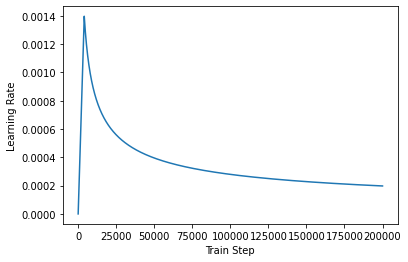

In [42]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# Step 5. 모델 컴파일

손실 함수와 커스텀 된 학습률(learning rate)을 사용하여 모델을 컴파일합니다.

In [43]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

# Step 6. 모델 훈련

In [44]:
EPOCHS = 10
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/10
185/185 [==============================] - 16s 53ms/step - loss: 1.4619 - accuracy: 0.0245
Epoch 2/10
185/185 [==============================] - 10s 53ms/step - loss: 1.1818 - accuracy: 0.0496
Epoch 3/10
185/185 [==============================] - 10s 53ms/step - loss: 1.0054 - accuracy: 0.0507
Epoch 4/10
185/185 [==============================] - 10s 54ms/step - loss: 0.9292 - accuracy: 0.0546
Epoch 5/10
185/185 [==============================] - 10s 54ms/step - loss: 0.8707 - accuracy: 0.0576
Epoch 6/10
185/185 [==============================] - 10s 54ms/step - loss: 0.8132 - accuracy: 0.0614
Epoch 7/10
185/185 [==============================] - 10s 55ms/step - loss: 0.7482 - accuracy: 0.0675
Epoch 8/10
185/185 [==============================] - 10s 55ms/step - loss: 0.6764 - accuracy: 0.0752
Epoch 9/10
185/185 [==============================] - 10s 55ms/step - loss: 0.5973 - accuracy: 0.0838
Epoch 10/10
185/185 [==============================] - 10s 55ms/step - loss: 0.514

# Step 7. 예측 모델 (인퍼런스 모델) 만들어 예측하기

예측(inference) 단계는 기본적으로 다음과 같은 과정을 거칩니다.

1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다. 
2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다. 
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다. 
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다. 
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다. 
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

In [45]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

# Step 8. 테스트 해보기

임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 sentence_generation() 함수를 만듭니다.

In [46]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [47]:
sentence_generation('이름이 뭐야?')

입력 : 이름이 뭐야?
출력 : 직접 물어보세요.


'직접 물어보세요.'

In [48]:
sentence_generation('나 돼지야??')

입력 : 나 돼지야??
출력 : 저도 좋아해요.


'저도 좋아해요.'

In [49]:
sentence_generation('어떻게 하면 너만큼 똑똑해질 수 있니??')

입력 : 어떻게 하면 너만큼 똑똑해질 수 있니??
출력 : 저도 좋아해요.


'저도 좋아해요.'

In [50]:
sentence_generation('날 왜 좋아한다고 하는거야?')

입력 : 날 왜 좋아한다고 하는거야?
출력 : 직접 물어보세요.


'직접 물어보세요.'

In [51]:
sentence_generation('속상하다ㅠㅠㅠ 왜 내 말을 못알아듣는거야ㅠㅠ')

입력 : 속상하다ㅠㅠㅠ 왜 내 말을 못알아듣는거야ㅠㅠ
출력 : 잘 지내고 있을 거예요.


'잘 지내고 있을 거예요.'

In [52]:
sentence_generation('쉬운거 물어볼께')

입력 : 쉬운거 물어볼께
출력 : 잘 지내고 있을 거예요.


'잘 지내고 있을 거예요.'

In [53]:
sentence_generation('제일 인기있는 한국 음식이 뭐야?')

입력 : 제일 인기있는 한국 음식이 뭐야?
출력 : 직접 물어보세요.


'직접 물어보세요.'

In [54]:
sentence_generation('힝ㅠㅠ 너랑 안놀아!')

입력 : 힝ㅠㅠ 너랑 안놀아!
출력 : 마세요.


'마세요.'

# 회고

## 입력 : 힝ㅠㅠ 너랑 안놀아!
## 출력 : 마세요.

ㅋㅋㅋㅋㅋㅋ  
너무 웃겨서 한참 웃었다. 이정도면 훌륭한 챗봇 아닙니까?! ㅋㅋㅋㅋ  
seq2seq보다는 오히려 구조가 쉬운것 같다.  
제목처럼 Attention all you need 과 확실하다  

엄청 어려웠지만 너무 재밌는 과제였다.  
이 과제를 하는데 3일을 새벽까지 보고 있었다.  
그 덕에 책도 볼 수 있었고, 자료들도 많이 찾아보게 되었다.  
내가 상대적으로 약하다고 생각하는 파이썬 코드구현은 openAI가 많이 도와줬고,  
조금 더 과정을 견고히 하기 위해 책을 참고하였다.  
그리고 케창딥을 하며 조금씩 읽어뒀던 부분들이 생각이 나기도 했다.  
점점 재밌어지는 느낌이다.  
잠을 못자서 어지럽긴 하지만,,   
중수와 하수를 구분하는 기준이 트랜스포머라고 했던 근철님 말씀이 생각나서  
그냥 끝까지 해보려 버텼다.  
NLP의 주요 모델들을 세 개 정도 구현해 본 것 같은데,  
이 기회가 너무 좋았고, 유익한 것 같다.   

### 어려웠던 점
1. Embedding + Positional vector 만드는 과정  
2. Multi head self attention 함수 안에 scaled dot 이 들어갈 때 작업 순서  
3. Self attention 작동 순서 이해하는 것
4. 정규표현식

### 참고  
Attention is All You Need https://arxiv.org/abs/1706.03762  
https://www.sciencedirect.com/science/article/abs/pii/S092523122100477X  
https://lilianweng.github.io/posts/2018-06-24-attention/  
https://velog.io/@idj7183/Attention-TransformerSelf-Attention  
https://medium.com/platfarm/%EC%96%B4%ED%85%90%EC%85%98-  %EB%A9%94%EC%BB%A4%EB%8B%88%EC%A6%98%EA%B3%BC-transfomer-self-attention-842498fd3225  
동빈나 유튜브 https://www.youtube.com/@dongbinna  
딥러닝을 이용한 지연어 처리 입문 https://wikidocs.net/book/2155  
데싸노트의 실전에서 통하는 머신러닝 (권시현 지음)  
머신러닝, 딥러닝 문제해결 전략 (신백균 지음)  
데이터 분석가가 반드시 알아야 할 모든것 (황세웅 지음)  


